# **Importing the required libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# **Merge the data scraped from web**

---



Path to the folder where your CSV files are located

In [2]:
folder_path = '/content/Data/'

List to store data from all CSV files

In [3]:
all_data = []

Iterate over all files in the folder and select the year-wise crime files

In [4]:
for file in os.listdir(folder_path):
    if file.startswith("GlobalCitiesCrimeStats"):  # Match the pattern of your file names
        file_path = os.path.join(folder_path, file)  # Get the full file path
        df = pd.read_csv(file_path)  # Read the CSV file
        # Optional: Make sure the 'Year' column is in the correct format
        df['Year'] = df['Year'].astype(int)
        # Add the DataFrame to the list
        all_data.append(df)

Concatenate all DataFrames into one

In [5]:
merged_data = pd.concat(all_data, ignore_index=True)

Sort the merged data by 'Year'

In [6]:
merged_data = merged_data.sort_values(by="Year", ascending=True)

Seperate the countries and cities

In [7]:
df = pd.DataFrame(merged_data)
df[['City', 'Country']] = df['City_name'].str.rsplit(',', n=1, expand=True)

Clean up any extra spaces

In [8]:
df[['City', 'Country']] = df[['City', 'Country']].apply(lambda x: x.str.strip())

Drop the original 'City_name' column & 'City_Safety_Index


In [9]:
df = df.drop(columns=['City_name'])
df = df.drop(columns=['City_Safety_Index','City_Rank'])

Save the sorted data to a new CSV file

In [10]:
output_file = '/content/SepMetaData.csv'
df.to_csv(output_file, index=False)
print(f"Merged and sorted CSV saved as {output_file}")

Merged and sorted CSV saved as /content/SepMetaData.csv


# **EDA**

In [11]:
data = pd.read_csv("/content/SepMetaData.csv")

# Count the number of years for each city
city_counts = data.groupby('City').size()

# Filter cities with at least 7 years of data
valid_cities = city_counts[city_counts >= 7].index

# Filter the dataset to include only valid cities
filtered_data = data[data['City'].isin(valid_cities)]

# Check the filtered data
print(filtered_data.head())

# Verify the number of years for each city in the filtered dataset
filtered_city_counts = filtered_data.groupby('City').size()
print("\nCities with the number of years (2015-2024):")
print(filtered_city_counts)

   Year  City_Crime_Index             City        Country
0  2015              28.9           Gdansk         Poland
1  2015              52.7      Orlando, FL  United States
2  2015              52.6        Tampa, FL  United States
3  2015              52.6          Colombo      Sri Lanka
4  2015              52.5  Minneapolis, MN  United States

Cities with the number of years (2015-2024):
City
Aalborg           9
Abu Dhabi        10
Ad Dammam         8
Addis Ababa       8
Adelaide         10
                 ..
Wroclaw          10
Yekaterinburg     7
Yerevan          10
Zagreb           10
Zurich           10
Length: 333, dtype: int64


In [13]:
output_path = "/content/Filtered_SepMetaData.csv"
filtered_data.to_csv(output_path, index=False)

(3185, 4)

# **Explore the DataFrame**

---



In [14]:
df = pd.read_csv('/content/Filtered_SepMetaData.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3185 non-null   int64  
 1   City_Crime_Index  3185 non-null   float64
 2   City              3185 non-null   object 
 3   Country           3185 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 99.7+ KB


In [16]:
df.describe()

,Year,City_Crime_Index
count,3185.000000,3185.000000
mean,2019.525589,44.623140
std,2.846147,15.777716
min,2015.000000,5.200000
25%,2017.000000,32.100000
50%,2020.000000,43.900000
75%,2022.000000,55.400000
max,2024.000000,91.100000


In [17]:
df.columns

Index(['Year', 'City_Crime_Index', 'City', 'Country'], dtype='object')

# **Visualization Before Prediction**

---



**Actual Data**

---



Path to Actual Dataset

In [18]:
df = pd.read_csv('/content/Filtered_SepMetaData.csv')

Replace with the city you want to visualize

In [19]:
city_name = 'Lahore'

Filter the actual df for 2015-2024

In [20]:
city_df = df[(df['City'] == city_name) & (df['Year'] >= 2015) & (df['Year'] <= 2024)]

**Plotting**

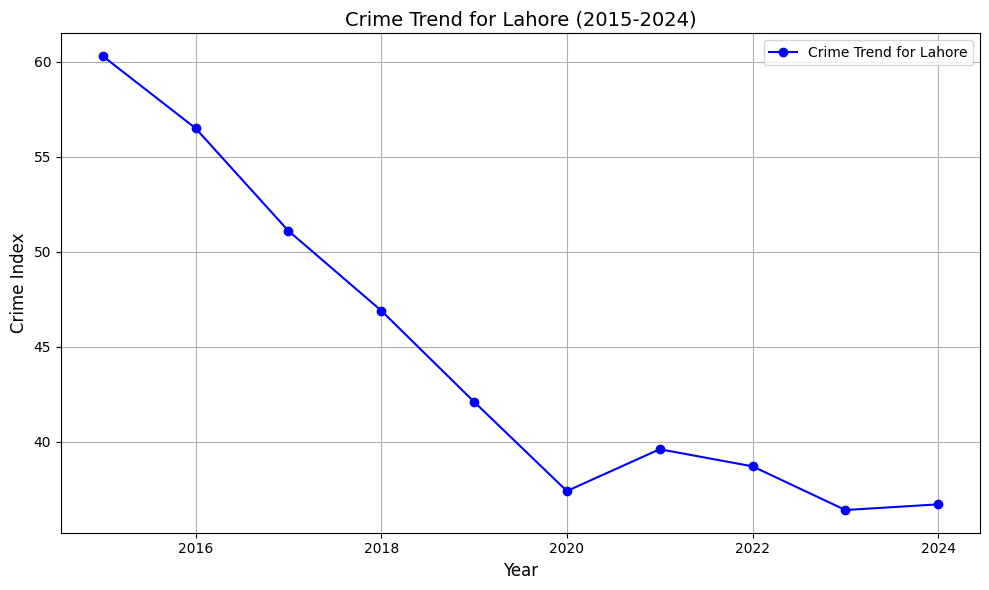

In [21]:
# Plot the crime trend for the selected city
plt.figure(figsize=(10, 6))
# Plot the crime df over years
plt.plot(city_df['Year'], city_df['City_Crime_Index'], marker='o', linestyle='-', color='b', label=f'Crime Trend for {city_name}')
# Add labels and title
plt.title(f'Crime Trend for {city_name} (2015-2024)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Crime Index', fontsize=12)
plt.grid(True)
# Add a legend to the plot
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()

# **Model Training**

---


Loading the cleaned dataset for training

In [22]:
file_path = '/content/Filtered_SepMetaData.csv'
dataset = pd.read_csv(file_path)

Cleaning the data strings

In [23]:
dataset['City'] = dataset['City'].str.split(',').str[0]
dataset['Country'] = dataset['Country'].str.split(',').str[0]
dataset.dropna(subset=['City', 'Country'], inplace=True)

Group data by City, Year, and Country and calculate the mean Crime Index for each city-year

In [24]:
city_grouped_data = dataset.groupby(['City', 'Year', 'Country'])['City_Crime_Index'].mean().reset_index()

Prophet requires a DataFrame with columns 'ds' (date) and 'y' (value to predict)
For Prophet, we'll create a 'ds' column as the 'Year' column (make sure it's in datetime format)

In [25]:
city_grouped_data['ds'] = pd.to_datetime(city_grouped_data['Year'].astype(str), format='%Y')
city_grouped_data['y'] = city_grouped_data['City_Crime_Index']

Initialize a list to store the predictions for each city

In [26]:
all_predictions = []

**Train our Prophet model**

In [27]:
for city in city_grouped_data['City'].unique():
    city_data = city_grouped_data[city_grouped_data['City'] == city]
    # Check if there are at least 2 non-NaN data points
    if city_data['y'].notna().sum() >= 2:
        # Initialize Prophet model
        model = Prophet()
        model.fit(city_data[['ds', 'y']])  # Train the model on 'ds' (Date) and 'y' (Crime Index)
        # Create a dataframe for future predictions (for the years 2025-2029)
        future_years = pd.date_range(start='2025-01-01', end='2029-12-31', freq='Y')
        future = pd.DataFrame({'ds': future_years})
        # Make predictions
        forecast = model.predict(future)
        # Store predictions with the city and country info
        country = city_data['Country'].iloc[0]
        for year, prediction in zip(forecast['ds'].dt.year, forecast['yhat']):
            all_predictions.append({'City': city, 'Country': country, 'Year': year, 'Predicted_City_Crime_Index': prediction})
    else:
       print(f"Skipping city '{city}' because it has less than 2 data points.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyvsmhx6i/ut9u_713.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyvsmhx6i/3pncekd9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70427', 'data', 'file=/tmp/tmpyvsmhx6i/ut9u_713.json', 'init=/tmp/tmpyvsmhx6i/3pncekd9.json', 'output', 'file=/tmp/tmpyvsmhx6i/prophet_model05jlnez5/prophet_model-20241219214137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Save predictions to a DataFrame

In [28]:
future_predictions = pd.DataFrame(all_predictions)
output_file_path = '/content/Future_Crime_Predictions_By_City_With_Country_Prophet.csv'
future_predictions.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")

Predictions saved to /content/Future_Crime_Predictions_By_City_With_Country_Prophet.csv


Display a sample of the predictions

In [29]:
print("Sample of Predictions:")
print(future_predictions.head())

Sample of Predictions:
      City  Country  Year  Predicted_City_Crime_Index
0  Aalborg  Denmark  2025                   31.798894
1  Aalborg  Denmark  2026                   34.497668
2  Aalborg  Denmark  2027                   37.417030
3  Aalborg  Denmark  2028                   29.668999
4  Aalborg  Denmark  2029                   32.143487


# **Now spliting our data by 20-80% for testing and evaluation**

---





Most of steps are same as previous

In [30]:
file_path = '/content/Filtered_SepMetaData.csv'
datasettest = pd.read_csv(file_path)

In [31]:
datasettest['City'] = datasettest['City'].str.split(',').str[0]
datasettest['Country'] = datasettest['Country'].str.split(',').str[0]
datasettest.dropna(subset=['City', 'Country'], inplace=True)

In [32]:
city_grouped_data = datasettest.groupby(['City', 'Year', 'Country'])['City_Crime_Index'].mean().reset_index()

In [33]:
city_grouped_data['ds'] = pd.to_datetime(city_grouped_data['Year'].astype(str), format='%Y')
city_grouped_data['y'] = city_grouped_data['City_Crime_Index']

In [34]:
all_predictions = []

In [35]:
# Train a Prophet model for each city
for city in city_grouped_data['City'].unique():
    city_data = city_grouped_data[city_grouped_data['City'] == city]
    # Check if there are at least 2 non-NaN data points
    if city_data['y'].notna().sum() >= 2:
        # Initialize Prophet model
        model = Prophet()
        model.fit(city_data[['ds', 'y']])  # Train the model on 'ds' (Date) and 'y' (Crime Index)
        # Create a dataframe for future predictions (for the years 2023-2024)
        future_years = pd.date_range(start='2023-01-01', end='2024-12-31', freq='Y')
        future = pd.DataFrame({'ds': future_years})
        # Make predictions
        forecast = model.predict(future)
        # Store predictions with the city and country info
        country = city_data['Country'].iloc[0]
        for year, prediction in zip(forecast['ds'].dt.year, forecast['yhat']):
            all_predictions.append({'City': city, 'Country': country, 'Year': year, 'Predicted_City_Crime_Index': prediction})
    else:
        print(f"Skipping city '{city}' because it has less than 2 data points.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyvsmhx6i/v5yhy1ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyvsmhx6i/m2w089ck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85913', 'data', 'file=/tmp/tmpyvsmhx6i/v5yhy1ky.json', 'init=/tmp/tmpyvsmhx6i/m2w089ck.json', 'output', 'file=/tmp/tmpyvsmhx6i/prophet_model06bkmsn4/prophet_model-20241219214609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:46:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [36]:
future_predictions = pd.DataFrame(all_predictions)
output_file_path = '/content/Future_Crime_Predictions_By_City_With_Country_Prophettest.csv'
future_predictions.to_csv(output_file_path, index=False)
print(f"Predictions saved to {output_file_path}")

Predictions saved to /content/Future_Crime_Predictions_By_City_With_Country_Prophettest.csv


In [37]:
print("Sample of Predictions:")
print(future_predictions.head())

Sample of Predictions:
        City               Country  Year  Predicted_City_Crime_Index
0    Aalborg               Denmark  2023                   37.072437
1    Aalborg               Denmark  2024                   29.324407
2  Abu Dhabi  United Arab Emirates  2023                   13.834390
3  Abu Dhabi  United Arab Emirates  2024                   11.286718
4  Ad Dammam          Saudi Arabia  2023                    4.876666


# **Now Evaluating Our Model**

---


Load the actual data

In [38]:
actual_data_path = '/content/Filtered_SepMetaData.csv'
actual_data = pd.read_csv(actual_data_path)

Filter actual data for 2023 and 2024

In [39]:
actual_data_2023_2024 = actual_data[actual_data['Year'].isin([2023, 2024])]

Load the predicted data

In [40]:
predicted_data_path = '/content/Future_Crime_Predictions_By_City_With_Country_Prophettest.csv'
predicted_data = pd.read_csv(predicted_data_path)

Merge the actual data (2023, 2024) with the predicted data (2023, 2024) on City and Year

In [41]:
merged_data = pd.merge(actual_data_2023_2024[['City', 'Year', 'City_Crime_Index']],
                       predicted_data[['City', 'Year', 'Predicted_City_Crime_Index']],
                       on=['City', 'Year'], how='inner')

Checking the data

In [42]:
# Check for missing values in merged data
print("Missing Values in Merged Data:")
print(merged_data.isna().sum())
# Drop rows where actual or predicted values are NaN
merged_data.dropna(subset=['City_Crime_Index', 'Predicted_City_Crime_Index'], inplace=True)

Missing Values in Merged Data:
City                          0
Year                          0
City_Crime_Index              0
Predicted_City_Crime_Index    0
dtype: int64


**Compute MAPE, MAE, RMSE**

In [43]:
if merged_data.empty:
    print("No matching data found for MAPE computation.")
else:
    merged_data['APE'] = abs((merged_data['City_Crime_Index'] - merged_data['Predicted_City_Crime_Index']) / merged_data['City_Crime_Index']) * 100
    mape = merged_data['APE'].mean()
    # MAPE (Mean Absolute Percentage Error) shows the average percentage error between predicted and actual values.
    print(f"MAPE: {mape:.4f}% (A value below 20% is generally considered acceptable, indicating good model performance)")

    # MAE (Mean Absolute Error) gives the average magnitude of errors between predicted and actual values in the same unit as the data.
    mae = mean_absolute_error(merged_data['City_Crime_Index'], merged_data['Predicted_City_Crime_Index'])
    print(f"MAE: {mae:.4f} (Lower MAE values indicate more accurate predictions. An MAE value below 5-10 units is generally considered good for most real-world applications)")

    # RMSE (Root Mean Squared Error) penalizes larger errors more than MAE and provides an indication of how far off predictions are from actual values.
    rmse = np.sqrt(mean_squared_error(merged_data['City_Crime_Index'], merged_data['Predicted_City_Crime_Index']))
    print(f"RMSE: {rmse:.4f} (An RMSE below 10-15% of the target variable’s range is generally considered acceptable for most models)")

MAPE: 11.4849% (A value below 20% is generally considered acceptable, indicating good model performance)
MAE: 4.5272 (Lower MAE values indicate more accurate predictions. An MAE value below 5-10 units is generally considered good for most real-world applications)
RMSE: 6.7528 (An RMSE below 10-15% of the target variable’s range is generally considered acceptable for most models)


# **Merging Datasets**

Load the actual and predicted data

In [44]:
actual_data = pd.read_csv("/content/Filtered_SepMetaData.csv")
predicted_data = pd.read_csv("/content/Future_Crime_Predictions_By_City_With_Country_Prophet.csv")

In [45]:
# Rename 'Predicted_City_Crime_Index' to 'City_Crime_Index' in the predicted_data
predicted_data.rename(columns={'Predicted_City_Crime_Index': 'City_Crime_Index'}, inplace=True)

# Merge the two dataframes on 'City', 'Country', and 'Year' with a full outer join
merged_data = pd.merge(actual_data, predicted_data, on=['City', 'Country', 'Year','City_Crime_Index'], how='outer')

# Save the merged data to a new CSV
merged_data.to_csv("Merged_DataSet.csv", index=False)

# Print the first few rows of the merged data
print("Merged data saved as 'merged_data.csv'.")
print(merged_data)

Merged data saved as 'merged_data.csv'.
      Year  City_Crime_Index     City      Country
0     2015         24.600000  Aalborg      Denmark
1     2016         31.200000  Aalborg      Denmark
2     2017         19.700000  Aalborg      Denmark
3     2018         19.800000  Aalborg      Denmark
4     2019         21.400000  Aalborg      Denmark
...    ...               ...      ...          ...
4840  2025         20.914833   Zurich  Switzerland
4841  2026         21.689406   Zurich  Switzerland
4842  2027         22.465756   Zurich  Switzerland
4843  2028         19.953391   Zurich  Switzerland
4844  2029         20.725148   Zurich  Switzerland

[4845 rows x 4 columns]


# **Visualization After Predictions**

---



**Predicted Data**

---



Load the dataset

In [46]:
file_path = '/content/Merged_DataSet.csv'
data = pd.read_csv(file_path)
data.columns

Index(['Year', 'City_Crime_Index', 'City', 'Country'], dtype='object')

Filter the data for a specific city

In [47]:
city_name = 'Delhi'

Customize the outputs

In [48]:
#Filter years for actual or predicted dataset
actual_city_data = actual_data[(actual_data['City'] == city_name) & (actual_data['Year'] >= 2015) & (actual_data['Year'] <= 2024)]
predicted_city_data = predicted_data[(predicted_data['City'] == city_name) & (predicted_data['Year'] >= 2025) & (predicted_data['Year'] <= 2029)]
#Rename the predicted column to match the actual data column name and combine both datasets
combined_data = pd.concat([actual_city_data[['Year', 'City_Crime_Index']], predicted_city_data[['Year', 'City_Crime_Index']]])

#Sort the combined data by year to ensure the timeline is continuous
data = combined_data.sort_values(by='Year')

**Plotting**

---



Plot the combined data as a continuous line



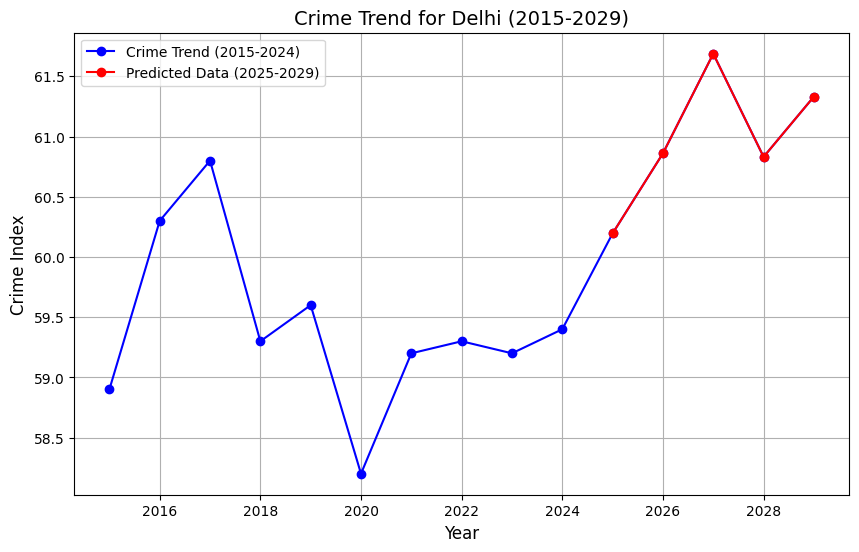

In [49]:
#Plot the crime trend for both actual and predicted data
plt.figure(figsize=(10, 6))

plt.plot(combined_data['Year'], combined_data['City_Crime_Index'], marker='o', linestyle='-', color='b', label='Crime Trend (2015-2024)')

plt.plot(predicted_city_data['Year'], predicted_city_data['City_Crime_Index'], marker='o', linestyle='-', color='r', label='Predicted Data (2025-2029)')
# Add labels and title
plt.title(f'Crime Trend for {city_name} (2015-2029)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Crime Index', fontsize=12)
plt.grid(True)

# Add a legend to the plot
plt.legend()
#Show the plot
plt.show()

# **Feature Engineering**

---


Load Dataset and Create DataFrame

In [68]:
data = pd.read_csv('/content/Merged_DataSet.csv')
df = pd.DataFrame(data)

Compute the Safety Index

In [69]:
df['City_Safety_Index'] = 100 - df['City_Crime_Index']

Normalize Crime Index (lower is better) and Safety Index (higher is better)
For Crime Index, we want lower values to be better, so we can reverse it.

In [70]:
df['Normalized_Crime'] = df['City_Crime_Index'].max() - df['City_Crime_Index']
df['Normalized_Safety'] = df['City_Safety_Index']

Combine the scores by giving equal weight or any custom weight

In [71]:
df['Combined_Score'] = df['Normalized_Crime'] + df['Normalized_Safety']

Rank cities based on the Combined Score (lower score means better rank)

In [72]:
df['Rank'] = df.groupby('Year')['Combined_Score'].rank(ascending=False, method='min').astype(int)

Compute Crime to Safety Ratio

In [73]:
df['Crime_to_Safety_Ratio'] = df['City_Crime_Index'] / df['City_Safety_Index']

Round-off decimal points

In [74]:
df['City_Crime_Index'] = df['City_Crime_Index'].round(1)
df['City_Safety_Index'] = df['City_Safety_Index'].round(1)
df['Crime_to_Safety_Ratio'] = df['Crime_to_Safety_Ratio'].round(1)

Define new bins for more categories

In [75]:
bins = [0, 25, 50, 75, 100, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

Assign the new categories based on Crime Index

In [76]:
df['Crime_Activity'] = pd.cut(df['City_Crime_Index'], bins=bins, labels=labels)

Defining a function to assign ratings based on Crime Index (1-5 scale)

In [77]:
def assign_detailed_rating_float(crime_index):
    if crime_index < 45:
        return 5.0  # Very Safe
    elif crime_index < 90:
        return 4.5  # Safe
    elif crime_index < 135:
        return 4.0  # Moderate
    elif crime_index < 180:
        return 3.5  # Unsafe
    elif crime_index < 225:
        return 3.0  # Very Dangerous
    elif crime_index < 270:
        return 2.5
    elif crime_index < 315:
        return 2.0
    elif crime_index < 360:
        return 1.5
    elif crime_index < 405:
        return 1.0
    else:
        return 0.5

Apply the rating functions to assign ratings (float scale)

In [78]:
df['Rating'] = df['Rank'].apply(assign_detailed_rating_float)

Function for detailed crime reviews (with dynamic changes every 5)

In [79]:
def assign_crime_review_detailed(crime_index):
    if crime_index < 9:
        return "This is one of the safest cities in the world. You can walk freely even at night without fear of crime. Very few incidents happen here, making it an ideal destination for tourists and residents alike."
    elif crime_index <18:
        return "The city has an exceptionally low crime rate. It's a peaceful and safe place to live and visit, where criminal activity is almost unheard of."
    elif crime_index < 27:
        return "Although crime is practically non-existent here, there are a few petty crimes, but they are few and far between. It's a great place for those who prioritize safety."
    elif crime_index < 36:
        return "City is very safe, with only occasional incidents. It's an excellent destination for anyone looking for a calm and secure environment."
    elif crime_index < 45:
        return "Crime rates are still very low here, but there are occasional reports of minor crimes like pickpocketing. It's generally a safe place, but visitors should still stay cautious in crowded areas."
    elif crime_index < 54:
        return "While Crime is still relatively low, though you may find more petty thefts or occasional burglaries. It's still a safe place for most tourists, but vigilance is advised."
    elif crime_index < 63:
        return "There are some noticeable levels of petty crime, especially in tourist-heavy areas. It’s still a relatively safe city, but you should take precautions, especially in busy areas."
    elif crime_index < 72:
        return "The crime rate is more pronounced here, and there are occasional violent crimes. While it’s still manageable, you’ll need to stay cautious, especially after dark."
    elif crime_index < 81:
        return "Safety concerns increase in certain parts of the city, especially during the night. Violent crimes are not uncommon, so it’s important to stay alert and avoid poorly lit areas."
    elif crime_index < 90:
        return "Seriously, that city faces notable crime challenges, with frequent reports of violent incidents. Visitors should exercise caution and avoid certain high-risk areas entirely."
    else:
        return "Omg the city has a high crime rate, with both violent and non-violent crimes prevalent in many areas. Extreme caution is advised, particularly at night."

Function for detailed safety reviews (with dynamic changes every 5)

In [80]:
def assign_safety_review_detailed(safety_index):
    if safety_index > 88:
        return "This city is extremely safe. Whether you're walking alone at night or exploring the city during the day, you'll feel at ease. Safety is a top priority here."
    elif safety_index > 80:
        return "A city with very safe with minimal crime. It's ideal for travelers who value a secure environment where they can walk without worry, even in less crowded areas."
    elif safety_index > 72:
        return "You’ll find this city to be quite safe, with friendly locals and a general sense of security. It's a good choice for travelers who want peace of mind while enjoying city life."
    elif safety_index > 64:
        return "Generally safe, with only a few areas where caution is needed. It’s a great place for tourists looking for a balance between safety and vibrant urban life."
    elif safety_index > 56:
        return "Safety is a concern in certain areas. While most parts of the city are safe, you should take extra care when walking in unfamiliar or poorly lit areas, especially at night."
    elif safety_index > 48:
        return "That city is relatively safe, but there are definite risks in certain areas. Travelers should avoid poorly lit neighborhoods, and it's a good idea to take a taxi rather than walking at night."
    elif safety_index > 40:
        return "Secure environment is a concern in many areas. You should be cautious, especially when walking in unfamiliar parts of the city, and it’s better to avoid certain neighborhoods, particularly after dark."
    elif safety_index > 32:
        return "Very unsafe in many parts, with higher crime rates and frequent reports of incidents. Visitors should be cautious at all times, especially when venturing off the main roads."
    elif safety_index > 24:
        return "This city has significant safety concerns. It’s essential to stay vigilant and avoid many areas, especially after dark. Always stay with a group and avoid certain neighborhoods."
    elif safety_index > 16:
        return "It faces serious safety issues, and it’s important to take extreme precautions. Crime is prevalent in many areas, and visitors should avoid certain neighborhoods altogether."
    elif safety_index > 8:
        return "This city is extremely dangerous. Avoid visiting most areas, and only travel in groups during the day. The risk of violent crime is significant."
    else:
        return "Ughhh! That city is a high-risk location, and safety is a major concern. It’s best to avoid visiting the city entirely or seek alternative destinations with a better security record."


Apply the functions to assign reviews based on Crime and Safety Index

In [81]:
df['Crime_Review'] = df['City_Crime_Index'].apply(assign_crime_review_detailed)
df['Safety_Review'] = df['City_Safety_Index'].apply(assign_safety_review_detailed)

Drop Extra Columns

In [82]:
df = df.drop(columns=['Combined_Score','Normalized_Crime','Normalized_Safety'])

Check if there are any null values in the entire DataFrame

In [88]:
has_nulls = df.isnull().any().any()
if has_nulls:
    print("The DataFrame contains null values.")
else:
    print("The DataFrame does not contain null values.")


The DataFrame contains null values.


Reorder the columns

In [84]:
column_order = [
    'Year', 'Country','City', 'Rank', 'City_Crime_Index',
    'City_Safety_Index','Rating','Crime_to_Safety_Ratio',
    'Crime_Activity', 'Crime_Review', 'Safety_Review'
]
df = df[column_order]

Save the output file

In [85]:
Feoutput_file = '/content/FECrime&TourismDataset.csv'
df.to_csv(Feoutput_file, index=False)
# Print message to confirm the file is saved
print(f"Merged and sorted CSV saved as {Feoutput_file}")

Merged and sorted CSV saved as /content/FECrime&TourismDataset.csv


To download the merged and FE file to your local machine

In [86]:
from google.colab import files
files.download(Feoutput_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>